In [11]:
# normal python
import os
import warnings
warnings.simplefilter('ignore')
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = None
import scipy as scp
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.labelsize'] = 16
import seaborn as sns
sns.set_palette('twilight')

from ptsa.data.concat import concat
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster 
# or SGECluster, etc. this is optional if you don't have a cluster available
# but this will be a challenge with such a large dataset
from mne_bids import (BIDSPath, read_raw_bids, find_matching_paths)
from nicls_helpers import *
from compute_scalp_features import compute_scalp_features

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load Subjects

In [2]:
subject_list = np.loadtxt("final_subject_list.txt", dtype=str)

## Computing features

In [3]:
# settings that specify the eeg epoch loaded (start/stop relative to stimulus onset)
# as well as other parameters for neural data processing including the frequencies for computing 
# spectral power and the width of the morlet wavelets
ro_settings = pickle.load(open("settings/phase1_settings.pkl", "rb"))
ro_settings['rel_start'] = -1200
ro_settings['rel_stop'] = -200
# pickle.dump(ro_settings, open("settings/phase1_settings_prestimulus.pkl", "wb"))
print("READ ONLY SETTINGS\n", ro_settings)
cl_settings = pickle.load(open("settings/phase2_settings.pkl", "rb"))
cl_settings['rel_start'] = -1616
cl_settings['rel_stop'] = -616
# pickle.dump(cl_settings, "/home1/jrudoler/optimizing-memory/settings/phase2_settings_early_prestimulus.pkl")
print("CLOSED LOOP SETTINGS\n", cl_settings)

READ ONLY SETTINGS
 {'rel_start': -1200, 'rel_stop': -200, 'buffer_time': 500, 'freqs': array([  6.        ,   9.75368156,  15.85571732,  25.77526961,
        41.90062864,  68.11423148, 110.72742057, 180.        ]), 'width': 5, 'experiment': 'NiclsCourierReadOnly', 'clean': 0, 'save': 1, 'reference': 'average'}
CLOSED LOOP SETTINGS
 {'rel_start': -1616, 'rel_stop': -616, 'buffer_time': 500, 'freqs': array([  6.        ,   9.75368156,  15.85571732,  25.77526961,
        41.90062864,  68.11423148, 110.72742057, 180.        ]), 'width': 5, 'experiment': 'NiclsCourierClosedLoop', 'clean': 0, 'save': 1, 'reference': 'average'}


In [4]:
# if running locally
client = Client()

# if running on HPC
# client = Client(
#     SLURMCluster(
#         job_name="NICLS",
#         memory="8GB",
#         cores=1,
#         processes=1,
#         walltime="01:00:00",
#         local_directory=os.expanduser("~/dask-worker-space/"),
#         log_directory=os.expanduser("~/logs/")
#     )
# )
# # adavptively scale workers based on demand
# client.cluster.adapt(minimum=0, maximum=100)

In [28]:
ro_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "settings/phase1_settings_prestimulus.pkl",
                        normalize = True,
                        save_path = '/scratch/nicls_intermediate/read_only/prestimulus_encoding_powers/')

In [9]:
cl_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "/home1/jrudoler/optimizing-memory/settings/phase2_settings_prestimulus.pkl",
                        normalize = True,
                        save_path = '/scratch/nicls_intermediate/closed_loop/prestimulus_encoding_powers/')

In [43]:
CL_evs = pd.read_csv("data/processed_events_NiclsCourierClosedLoop.csv", index_col=0)
settings_path = "/home1/jrudoler/optimizing-memory/settings/phase2_settings_early_prestimulus.pkl"
save_path = '/scratch/nicls_intermediate/closed_loop/early_prestimulus_encoding_powers/'
futures = client.map(compute_scalp_features,
                        subject_list,
                        settings_path=settings_path,
                        normalize=False,
                        save_path=save_path)

## Decoding memory success

In [30]:
encoding_futures = client.map(
    load_and_fit_data_encoding, 
    [f"/scratch/nicls_intermediate/read_only/prestimulus_encoding_powers/{sub}_feats.h5" for sub in subject_list],
    group="session"
)

In [31]:
gathered_results_encoding = client.gather(encoding_futures)
full_results_encoding = pd.concat(gathered_results_encoding)
full_results_encoding.to_pickle("results/prestimulus_RO_classification_results_encoding.pkl")

### Encoding ROC

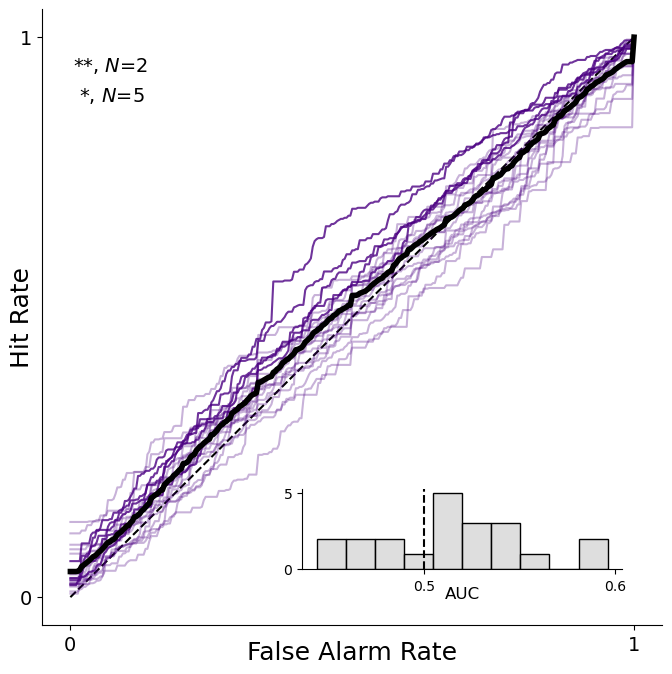

In [39]:
full_results_encoding = pd.read_pickle("results/prestimulus_RO_classification_results_encoding.pkl")

encoding_signif = {}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], '--k')
base_fp = np.linspace(0, 1, 301)
tp_list = []
all_subjects_auc = []
all_subjects_null_auc = []

for subject, subject_results in full_results_encoding.groupby("subject"):
#     print(subject)
    subject_tp = []
    auc = []
    auc_null = []
    for i, row in subject_results.iterrows():
        if np.mean(row["y_true"]) in [0., 1.]:
            continue
        auc.append(row["AUC"])
        auc_null.append(row["null"])
        tp = np.interp(base_fp, row['fp'], row['tp'])
        subject_tp.append(tp)
    auc_null = np.vstack(auc_null).mean(0)
    auc = np.mean(auc)
    all_subjects_auc.append(auc)
    all_subjects_null_auc.append(np.mean(auc_null))
    p = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    encoding_signif.update({subject:p})
    if p<=0.05:
        alpha=0.8
    else:
        alpha=0.3
    tp_list.append(np.mean(subject_tp, axis=0))
    ax.plot(base_fp, np.mean(subject_tp, axis=0), color='indigo', label=f"{subject}, AUC = {row['AUC']:.3f}", alpha=alpha)

top_ax = fig.add_axes([0.45, .18, .4, .1])
auc_dist = pd.DataFrame({"subject":np.unique(full_results_encoding["subject"]), "auc":all_subjects_auc})
auc_dist['p'] = auc_dist["subject"].map(encoding_signif) 
auc_dist['signif'] = auc_dist['p']<.05
top_ax.axvline(0.5, color='k', ls='--')
sns.histplot(auc_dist, x="auc", bins=10, ax=top_ax, color='lightgrey')
top_ax.grid(False)
# top_ax.set_title('AUC', fontsize=14)
top_ax.set_xticks([.5, .6])
top_ax.spines['top'].set_visible(False)
top_ax.spines['right'].set_visible(False)
top_ax.set_xlabel('AUC', fontsize=12, labelpad=-5)
top_ax.set_ylabel('')    

ax.plot(base_fp, np.mean(np.vstack(tp_list), 0), color='k', lw = 4, alpha=1)
# ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))
ax.set_ylabel('Hit Rate', fontsize=18, labelpad=-10)
ax.set_xlabel('False Alarm Rate', fontsize=18, labelpad=-10)
ax.grid(False)
ax.tick_params(labelsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

_ = ax.annotate(fr"**, $N$={sum(np.array(list(encoding_signif.values()))<=.01)}", xy=(.05, .9), xycoords="axes fraction", fontsize=16)
_ = ax.annotate(fr" *, $N$={sum(np.array(list(encoding_signif.values()))<=.05)}", xy=(.05, .85), xycoords="axes fraction", fontsize=16)

plt.savefig('figures/prestimulus_nested_loso_encoding.png', dpi=200, bbox_inches='tight')

In [38]:
scp.stats.ttest_1samp(full_results_encoding.groupby("subject").agg({"AUC":"mean"}), 0.5)

Ttest_1sampResult(statistic=array([1.89328413]), pvalue=array([0.07288037]))

In [36]:
mean = full_results_encoding.groupby("subject").agg({"AUC":"mean"}).mean()[0]
sem = full_results_encoding.groupby("subject").agg({"AUC":"mean"}).sem()[0]
print(f"mean AUC = {mean:.4f} +/- {sem:.4f} ")

mean AUC = 0.5163 +/- 0.0086 


### One-list normalization for closed loop

In [25]:
path = '/scratch/nicls_intermediate/closed_loop/early_prestimulus_encoding_powers/'
base_fp = np.linspace(0, 1, 301)

cl_result_dict = {}
session_level_results = {}
# behavioral events with classifier information integrated
CL_evs = pd.read_csv("data/processed_events_NiclsCourierClosedLoop.csv", index_col=0)

for i, subject in tqdm(list(enumerate(subject_list))):
    ts = TimeSeries.from_hdf(path+subject+"_raw_feats.h5", engine="netcdf4")
    evs = CL_evs.query(f'type=="WORD"&subject=="{subject}"').reset_index()
    
    ts = ts.groupby('session').apply(norm_sess_feats, n_lists=1)
    
    model = ClassifierModel(
        LogisticRegression()
    ).load_json(f"/data/eeg/scalp/ltp/NiclsCourierReadOnly/{subject}/nicls_{subject}_classifier.json").model
    evs = evs.query('trial_type in ["Sham", "NoStim"]')
    sham_powers = ts.isel(event=evs.index)
    auc = []
    auc_null = []
    subject_tp = []
    session_level_results[subject] = {}
    for sess, sess_pows in sham_powers.groupby("session"): 
        prob = model.predict_proba(sess_pows.data)[:, 1]
        if np.mean(sess_pows.recalled.values) in [0., 1.]:
            continue
        fp, tp, _ = roc_curve(sess_pows.recalled.values, prob)
        tp = np.interp(base_fp, fp, tp)
        subject_tp.append(tp)
        score, null, p_val = post_hoc_permutation(y_true=sess_pows.recalled.values, y_score = prob)
        session_level_results[subject][sess] = (score, null, p_val)
        auc.append(score)
        auc_null.append(null)
    auc_null = np.vstack(auc_null).mean(0)
    auc = np.mean(auc)
    p = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    cl_result_dict[subject] = (fp, np.mean(subject_tp, axis=0), auc, auc_null)

  0%|          | 0/21 [00:00<?, ?it/s]

In [26]:
with open(f"early_prestimulus_CL_classification_results_encoding.pkl", "wb") as f:
    pickle.dump(cl_result_dict, f)
df_session_results = pd.DataFrame(session_level_results).melt(var_name="subject")
df_session_results[["score", "perm_scores", "pval"]] = df_session_results['value'].apply(pd.Series)
df_session_results = df_session_results.dropna().drop(columns=["value"])
df_session_results["session"] = df_session_results.groupby("subject").cumcount()
df_session_results.to_pickle("early_prestimulus_CL_session_classification_results.pkl")
df_session_results

,subject,score,perm_scores,pval,session
0,LTP462,0.657366,"[0.5580357142857143, 0.38058035714285704, 0.62...",0.0202,0
1,LTP462,0.581515,"[0.5275994865211809, 0.5750962772785623, 0.449...",0.1602,1
4,LTP468,0.482057,"[0.5227272727272727, 0.5215311004784688, 0.515...",0.5834,0
5,LTP468,0.600470,"[0.5052878965922445, 0.535840188014101, 0.4864...",0.1018,1
8,LTP470,0.660633,"[0.502262443438914, 0.5316742081447964, 0.5316...",0.0214,0
...,...,...,...,...,...
79,LTP498,0.507500,"[0.475, 0.48250000000000004, 0.56125, 0.4075, ...",0.4634,3
80,LTP500,0.411429,"[0.5051428571428571, 0.48342857142857143, 0.62...",0.8770,0
81,LTP500,0.458145,"[0.5260180995475112, 0.43552036199095023, 0.47...",0.7034,1
82,LTP500,0.505682,"[0.5625, 0.5113636363636364, 0.482954545454545...",0.4926,2


In [59]:
df_session_results = pd.read_pickle("early_prestimulus_CL_session_classification_results.pkl")

In [60]:
scp.stats.ttest_1samp(df_session_results.groupby("subject").agg({"score":"mean"}), 0.5)

Ttest_1sampResult(statistic=array([2.29946513]), pvalue=array([0.0323833]))

In [61]:
mean = df_session_results.groupby("subject").agg({"score":"mean"}).mean()[0]
sem = df_session_results.groupby("subject").agg({"score":"mean"}).sem()[0]
print(f"mean AUC = {mean:.4f} +/- {sem:.4f} ")

mean AUC = 0.5481 +/- 0.0209 


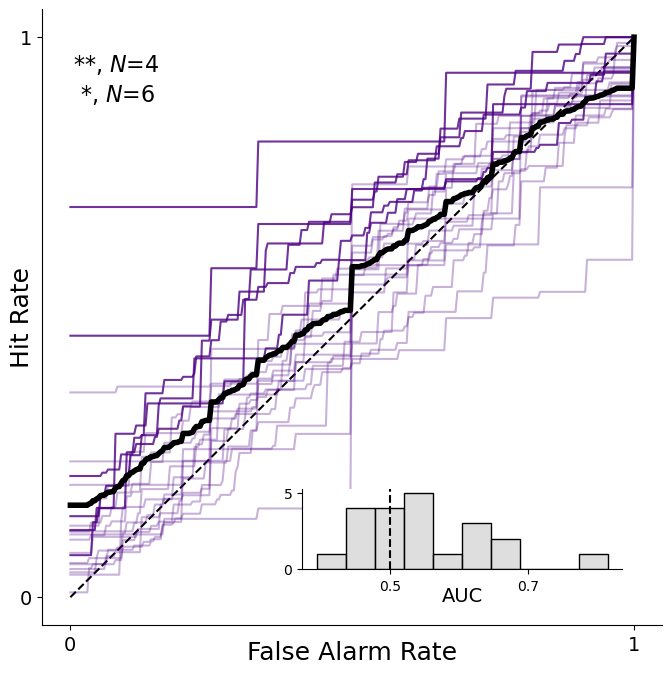

In [30]:
with open(f"early_prestimulus_CL_classification_results_encoding.pkl", "rb") as f:
    cl_result_dict = pickle.load(f)
encoding_signif = {}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], '--k')
base_fp = np.linspace(0, 1, 301)
tp_list = []
all_subjects_auc = []
all_subjects_null_auc = []

for subject in cl_result_dict:
#     print(subject)
    (fp, tp, auc, auc_null) = cl_result_dict[subject]
    all_subjects_auc.append(auc)
    all_subjects_null_auc.append(np.mean(auc_null))
    p = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    encoding_signif.update({subject:p})
    if p<=0.05:
        alpha=0.8
    else:
        alpha=0.3
    tp_list.append(tp)
    ax.plot(base_fp, tp, color='indigo', label=f"{subject}, AUC = {auc:.3f}", alpha=alpha)

top_ax = fig.add_axes([0.45, .18, .4, .1])
auc_dist = pd.DataFrame({"subject":np.array([s for s in cl_result_dict]), "auc":all_subjects_auc})
auc_dist['p'] = auc_dist["subject"].map(encoding_signif) 
auc_dist['signif'] = auc_dist['p']<.05
top_ax.axvline(0.5, color='k', ls='--')
sns.histplot(auc_dist, x="auc", bins=10, ax=top_ax, color='lightgrey')
top_ax.grid(False)
top_ax.set_xticks([.5, .7])
top_ax.spines['top'].set_visible(False)
top_ax.spines['right'].set_visible(False)
top_ax.set_xlabel('AUC', fontsize=14, labelpad=-5)
top_ax.set_ylabel('')    

ax.plot(base_fp, np.mean(np.vstack(tp_list), 0), color='k', lw = 4, alpha=1)
# ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))
ax.set_ylabel('Hit Rate', fontsize=18, labelpad=-10)
ax.set_xlabel('False Alarm Rate', fontsize=18, labelpad=-10)
ax.grid(False)
ax.tick_params(labelsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

_ = ax.annotate(fr"**, $N$={sum(np.array(list(encoding_signif.values()))<=.01)}", xy=(.05, .9), xycoords="axes fraction", fontsize=16)
_ = ax.annotate(fr" *, $N$={sum(np.array(list(encoding_signif.values()))<=.05)}", xy=(.05, .85), xycoords="axes fraction", fontsize=16)

plt.savefig('figures/early_prestimulus_CL_nested_loso_encoding.png', dpi=200, bbox_inches='tight')

In [37]:
performance_stats = pd.read_csv("data/system_performance_stats.csv", header=[0, 1], index_col=[0, 1])
print(f"Losing {performance_stats['bad_session'].values.sum()} sessions with bad system performance")
CL_evs = pd.read_csv("data/processed_events_NiclsCourierClosedLoop.csv", index_col=0)
CL_evs = pd.concat([CL_evs.groupby(["subject", "session"]).get_group(g) for g in performance_stats[~performance_stats['bad_session'].values].index])
df_session_results = pd.read_pickle("early_prestimulus_CL_session_classification_results.pkl")
scores = df_session_results.groupby("subject", as_index=False).agg({"score":"mean"}).rename(columns={"score":"AUC"})
CL_evs = pd.merge(CL_evs, scores, on="subject")
CL_evs.to_csv("data/processed_events_with_prestim_AUC.csv")
encoding_evs = CL_evs.query("type=='WORD' and trial_type!='NoStim'")

Losing 7 sessions with bad system performance


In [57]:
recall_by_trial_type = encoding_evs.groupby(["subject", "trial_type"], as_index=False).agg({"recalled":"mean", "AUC":"mean"})
trial_type_comparisons = pd.DataFrame({"subject":recall_by_trial_type["subject"].unique(), "AUC":recall_by_trial_type["AUC"].round(15).unique()})
trial_type_comparisons["Optimize vs. Impair"] = recall_by_trial_type.query("trial_type=='Pos'")["recalled"].values - recall_by_trial_type.query("trial_type=='Neg'")["recalled"].values
trial_type_comparisons["Optimize vs. Control"] = recall_by_trial_type.query("trial_type=='Pos'")["recalled"].values - recall_by_trial_type.query("trial_type=='Sham'")["recalled"].values
trial_type_comparisons["Impair vs. Control"] = recall_by_trial_type.query("trial_type=='Neg'")["recalled"].values - recall_by_trial_type.query("trial_type=='Sham'")["recalled"].values
pivoted_trial_comparisons = trial_type_comparisons.melt(id_vars=["subject", "AUC"],value_vars=["Optimize vs. Impair", "Optimize vs. Control", "Impair vs. Control"], value_name="delta_recall", var_name="comparison")

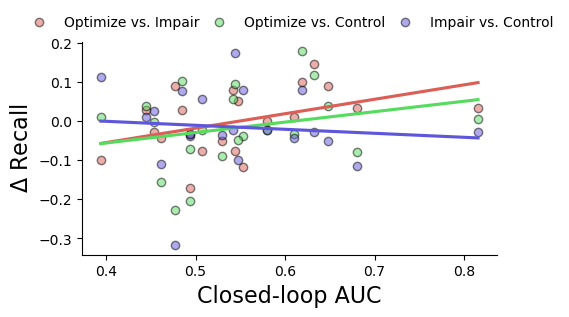

In [58]:
sns.set_palette('hls', 3)
# fig, ax = plt.subplots(1, 1)
facet = sns.lmplot(data=pivoted_trial_comparisons, 
                   scatter_kws = dict(alpha=0.5, edgecolor='k'),
                   x="AUC", y="delta_recall", hue="comparison",
                   legend=True, ci=None, height=3, aspect=1.8, legend_out=True)
ax= facet.axes[0][0]
ax.set_ylabel(r"$\Delta$ Recall")
ax.set_xlabel("Closed-loop AUC")
ax.legend(facet._legend_data.values(), facet._legend_data)
facet.legend.remove()
sns.move_legend(
    ax, "lower center", handles=facet._legend_data.values(), labels=facet._legend_data,
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False, 
    columnspacing=.4,
    # labelspacing=1., handlelength=0.8, handletextpad=1,
)

## Behavioral plots

In [67]:
# check that recall is comparable to phase 1 (read-only) sessions
bids_root = os.path.expanduser("~/data/nicls_bids/")
event_paths = find_matching_paths(
    root=bids_root,
    tasks="NiclsCourierReadOnly",
    subjects=subject_list,
    suffixes="events",
    extensions=".tsv"
    )
RO_evs = []
for p in event_paths:
    evs = pd.read_csv(p.fpath, sep='\t')
    evs["recalled"] = evs.query("trial_type=='WORD'")\
        .apply(lambda x: x["item"] in evs.query("trial_type=='REC_WORD'").item.values, axis=1)
    RO_evs.append(evs)

RO_evs = pd.concat(RO_evs).sort_values(["subject", "session", "onset"]).reset_index(drop=True)
RO_evs = RO_evs[(RO_evs.trial_type=='WORD')&(RO_evs.sample!=-1)].reset_index(drop=True)
CL_evs = pd.read_csv("data/processed_events_NiclsCourierClosedLoop.csv", index_col=0)\
    .query("trial_type in ['NoStim', 'Sham'] and type=='WORD'")

Text(0, 0.5, 'Recall')

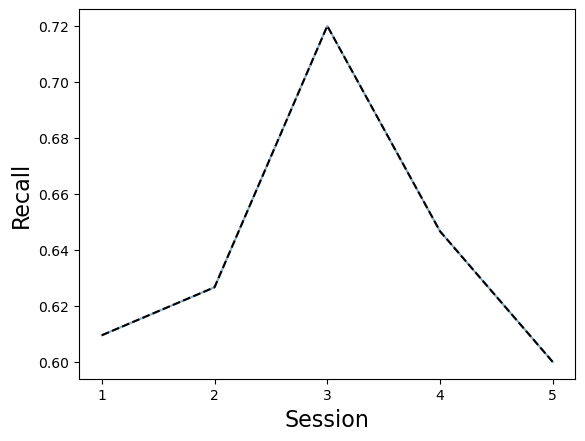

In [69]:
ax = sns.lineplot(
    data=RO_evs.query("session < 5"),
    x="session",
    y="recalled",
    hue="subject",
    err_style=None,
    legend=None
)
sns.lineplot(
    data=RO_evs.query("session < 5").groupby(["subject", "session"]).agg({"recalled":"mean"}),
    x="session",
    y="recalled",
    color='k',
    linestyle="--",
    err_style="band",
    legend=None
)
ax.set_xticks(range(5))
ax.set_xticklabels(range(1, 6))
ax.set_xlabel("Session")
ax.set_ylabel("Recall")
# plt.savefig("figures/recall_RO_across_sessions.png", dpi=200, bbox_inches="tight")

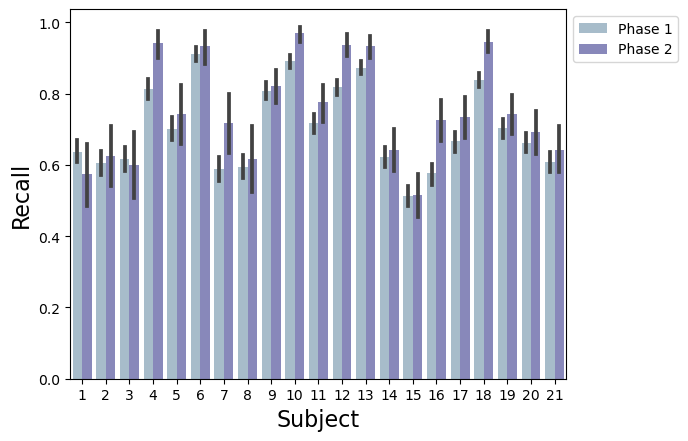

In [88]:
plot_data = pd.concat([RO_evs, CL_evs])
ax = sns.barplot(data=plot_data, x="subject", y="recalled", hue="experiment", alpha=0.8)
ax.set_xticklabels(labels=range(1, 22))
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
legend_handles, _ = ax.get_legend_handles_labels()
ax.legend(legend_handles, ["Phase 1", "Phase 2"], 
          loc="upper left",
          bbox_to_anchor=(1,1), 
          title=None)
# plt.legend("upper left", bbox_to_anchor=(1, 1), labels=["Phase 1", "Phase 2"])
ax.set_xlabel("Subject")
ax.set_ylabel("Recall")
plt.savefig("figures/recall_by_subject_and_phase.png", dpi=200, bbox_inches="tight")